In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import KFold
import csv
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import re

In [2]:
from collections import defaultdict

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.chdir("/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML")

In [5]:
data_path = "/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/sharePublic/Public"
col_name = ['path', 'category_id']
categories = {
    'Others': 0,
    'Honda': 1,
    'Hyundai': 2,
    'KIA': 3,
    'Mazda': 4,
    'Mitsubishi': 5,
    'Suzuki': 6,
    'Toyota': 7,
    'VinFast': 8,
}

# TẠO CÁC TẬP DỮ LIỆU TRAIN, TEST (SPLITS)


---





In [ ]:
X = []
y = []
for category in os.listdir(data_path):
    category_path = os.path.join(data_path, category)
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            if image_name.split('.')[-1].lower() in ['png', 'jpg', 'jpeg']:
              X.append(os.path.join(category, image_name))
              y.append(categories[category])

In [ ]:
#Split thành nhiều dataset
NumSplits = 5
kf = KFold(n_splits=NumSplits, shuffle=True, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(X)):
  with open(f'/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/Public/CarDataset-Splits-{i+1}-Train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for item in train_index:
      writer.writerow([X[item], y[item]])
  with open(f'/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/Public/CarDataset-Splits-{i+1}-Test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for item in test_index:
      writer.writerow([X[item], y[item]])

In [6]:
#Dataset tổng
with open('/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/Public/CarDatasetTrain.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['path', 'category_id'])
    for category, category_id in categories.items():
        category_path = os.path.join(data_path, category)
        for image_name in os.listdir(category_path):
            if image_name.split('.')[-1].lower() in ['png', 'jpg', 'jpeg']:
                writer.writerow([os.path.join(category, image_name), category_id])

In [7]:
df = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/Public/CarDataset-Splits-1-Train.csv')
df.columns = ['image_name', 'category_id']
df

,image_name,category_id
0,Mitsubishi/22520394-22520395.Mitsubishi.172.jpg,5
1,Mitsubishi/22520394-22520395.Mitsubishi.315.jpg,5
2,Mitsubishi/22520394-22520395.Mitsubishi.114.jpg,5
3,Mitsubishi/22520394-22520395.Mitsubishi.127.jpg,5
4,Mitsubishi/22520394-22520395.Mitsubishi.336.jpg,5
...,...,...
30246,VinFast/22521027-22520195-22521060.VinFast.103...,8
30247,VinFast/22521027-22520195-22521060.VinFast.102...,8
30248,VinFast/22521027-22520195-22521060.VinFast.102...,8
30249,VinFast/22521027-22520195-22521060.VinFast.103...,8


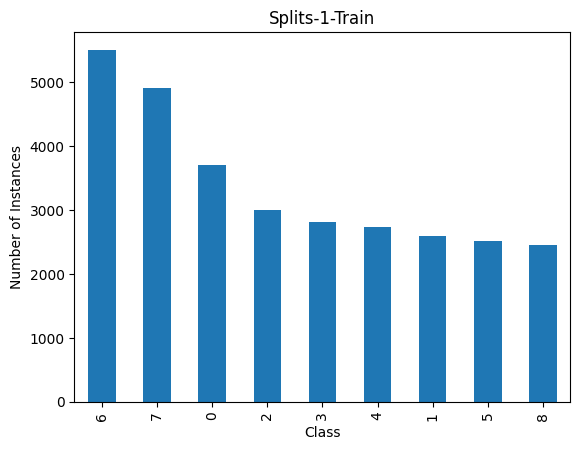

In [8]:
class_counts = df['category_id'].value_counts()
class_counts.plot(kind='bar')
plt.title('Splits-1-Train')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

# THỐNG KÊ DỮ LIỆU
---


In [13]:
def check_valid_file_name(filename):
    try:
        filename = filename.lower().split('.')
        if len(filename) != 4 or filename[-1] not in ['jpg', 'jpeg', 'png']:
            return None, None, None
        mssv, brand, order = filename[0], filename[1], filename[2]
        contributes = mssv.split('-')
        num_pattern = r'^\d+$'
        if not re.match(num_pattern, order):
            return None, None, None
        valid_contributes = contributes.copy()
        for contribute in contributes:
            if not re.match(num_pattern, contribute):
                return None, None, None
            if len(contribute) != 8:
                valid_contributes.remove(contribute)
        return valid_contributes, brand, order
    except Exception as e:
      print(f'Error occurred while processing file {filename}: {e}')
      return None, None, None

In [14]:
car_brands = ('Others', 'Honda', 'Hyundai', 'KIA', 'Mazda', 'Mitsubishi', 'Suzuki', 'Toyota', 'VinFast')

student_total_brands = defaultdict(float)
student_per_brand = defaultdict(lambda: defaultdict(float))

for car_brand in car_brands:
    brand_path = os.path.join(data_path, car_brand)
    for entry in os.scandir(brand_path):
        if entry.is_file():
            filename = entry.name
            contributes, brand, order = check_valid_file_name(filename)
            if contributes is None:
                continue
            brand = brand.title()
            if brand not in car_brands:
                brand = 'Others'
            contribute_weight = 1 / len(contributes)
            for contribute in contributes:
                student_total_brands[contribute] += contribute_weight
                student_per_brand[contribute][brand] += contribute_weight

In [15]:
import json

In [16]:
print(json.dumps(student_total_brands, indent=4))

{
    "22520394": 1683.5,
    "22520395": 1683.5,
    "22521560": 249.5,
    "22521614": 249.5,
    "21522500": 507.5,
    "21522771": 507.5,
    "22521492": 377.0,
    "22521599": 377.0,
    "22520348": 158.0000000000001,
    "22520530": 158.0000000000001,
    "22520837": 158.0000000000001,
    "22521692": 620.0,
    "22521676": 620.0,
    "22520779": 1360.5,
    "22521587": 1360.5,
    "22521425": 73.0,
    "22520318": 73.0,
    "22521463": 114.66666666666612,
    "22521213": 114.66666666666612,
    "22521259": 114.66666666666612,
    "22520459": 1259.6666666666595,
    "22520507": 1259.6666666666595,
    "22520862": 1259.6666666666595,
    "22521586": 723.0,
    "22521559": 723.0,
    "22521070": 1230.0,
    "22520211": 1230.0,
    "22521342": 999.5,
    "22520970": 999.5,
    "22520477": 289.0,
    "22520490": 289.0,
    "22521027": 3989.666666667363,
    "22520195": 3989.666666667363,
    "22521060": 3989.666666667363,
    "21522373": 350.0,
    "21522499": 351.0,
    "22520521": 

In [17]:
print(json.dumps(student_per_brand, indent=4))

{
    "22520394": {
        "Others": 576.0,
        "Honda": 193.5,
        "Hyundai": 126.5,
        "Mazda": 160.5,
        "Mitsubishi": 211.0,
        "Suzuki": 233.0,
        "Toyota": 183.0
    },
    "22520395": {
        "Others": 576.0,
        "Honda": 193.5,
        "Hyundai": 126.5,
        "Mazda": 160.5,
        "Mitsubishi": 211.0,
        "Suzuki": 233.0,
        "Toyota": 183.0
    },
    "22521560": {
        "Others": 72.5,
        "Honda": 24.0,
        "Hyundai": 25.0,
        "Mazda": 27.5,
        "Mitsubishi": 22.0,
        "Suzuki": 26.5,
        "Toyota": 52.0
    },
    "22521614": {
        "Others": 72.5,
        "Honda": 24.0,
        "Hyundai": 25.0,
        "Mazda": 27.5,
        "Mitsubishi": 22.0,
        "Suzuki": 26.5,
        "Toyota": 52.0
    },
    "21522500": {
        "Others": 117.5,
        "Honda": 80.5,
        "Hyundai": 100.0,
        "Mazda": 18.0,
        "Mitsubishi": 24.0,
        "Suzuki": 83.5,
        "Toyota": 84.0
    },
    "21

# Hiển thị nhiều ảnh
---



In [ ]:
def display_random_car(data, root_path, num_img_per_row=10, img_height=1.5, img_width=1.5):
    cars_brand_set = {0 : 'Other', 1 : 'Honda', 2 : 'Hyundai', 3 : 'KIA',
                    4 : 'Mazda', 5 : 'Mitsubishi', 6 : 'Suzuki',
                    7 : 'Toyota', 8 : 'VinFast'}
    group_data = data.groupby('category_id')
    category_ids = group_data.groups.keys()
    num_categories = len(category_ids)
    w_ratios = [2] + [1 for _ in range(num_img_per_row)]
    h_space = 0.1
    w_space = 0.1
    w_size = img_width * sum(w_ratios) + w_space * (len(w_ratios) - 1)
    h_size = img_height * num_categories + h_space * (num_categories - 1)
    fig, axes = plt.subplots(nrows=num_categories, ncols=num_img_per_row + 1,
                           figsize=(w_size, h_size),
                           gridspec_kw={'width_ratios': w_ratios, 'wspace' : w_space, 'hspace' : h_space})
    for i, category_id in enumerate(category_ids):
        brand_name = cars_brand_set[category_id]
        axes[i,0].text(0, 0.5, f'{brand_name}', ha = 'left', va = 'center', fontsize = img_width * 15, fontweight='bold')
        image_paths = group_data.get_group(category_id)['path'].tolist()
        random_sample = random.sample(image_paths, num_img_per_row)

        for j, image_path in enumerate(random_sample):
            random_path = os.path.join(root_path, image_path)
            img = Image.open(random_path)
            axes[i,j+1].imshow(img, aspect='auto')
            axes[i,j+1].axis('off')
        axes[i,0].axis('off')
    plt.show()

In [ ]:
total_dataset_path = '/content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/Public/CarDatasetTrain.csv'
df = pd.read_csv(total_dataset_path)
display_random_car(df, data_path)

Output hidden; open in https://colab.research.google.com to view.

# Clustering
---



In [ ]:
import pandas as pd
import tensorflow as tf
import torch
from torchvision.transforms import ToTensor
import cv2
import torch
from sklearn.cluster import DBSCAN
from tensorflow.keras.utils import load_img
import numpy as np
import matplotlib.pyplot as plt
import os
from torchvision.transforms import ToTensor, Compose, Resize
from math import ceil
from tensorflow.keras.applications import MobileNet
from PIL import Image, UnidentifiedImageError
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Flatten

In [ ]:
model = MobileNet(weights="imagenet", include_top=False, pooling="avg")

<ipython-input-9-fb61bcce3659>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  model = MobileNet(weights="imagenet", include_top=False, pooling="avg")


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
car_dataset = pd.read_csv(data_path + '/CarDatasetTrain.csv')

In [ ]:
col_name = ['path', 'category_id']
car_dataset.columns = col_name

In [ ]:
car_dataset

,path,category_id
0,Others/22521027-22520195-22521060.Others.122.jpg,0
1,Others/22521027-22520195-22521060.Others.527.jpg,0
2,Others/22521027-22520195-22521060.Others.553.jpg,0
3,Others/22521027-22520195-22521060.Others.222.jpg,0
4,Others/22521027-22520195-22521060.Others.263.jpg,0
...,...,...
19141,VinFast/22521027-22520195-22521060.VinFast.056...,8
19142,VinFast/22521027-22520195-22521060.VinFast.067...,8
19143,VinFast/22521027-22520195-22521060.VinFast.059...,8
19144,VinFast/22521027-22520195-22521060.VinFast.059...,8


In [ ]:
def display_cluster_images(cluster_id, image_paths, brand, n_cols=5):
    print(f"Cluster {cluster_id} - Brand: {brand}")
    n_images = len(image_paths)
    n_rows = ceil(n_images/n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axes = axes.flatten()
    for i, image_path in enumerate(image_paths):
        try:
            image_path = data_path + f'/{brand}/{image_path}'
            img = load_img(image_path)
            axes[i].imshow(img)
            axes[i].set_title(os.path.basename(image_path), fontsize=8)
            axes[i].axis("off")
        except Exception as e:
            print(f'Error occurred while loading image {image_path}: {e}')
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
paths = car_dataset['path']
car_brands = ('Others', 'Honda', 'Hyundai', 'KIA', 'Mazda', 'Mitsubishi', 'Suzuki', 'Toyota', 'VinFast')
features = []
batch_size = 8
transform = Compose([Resize((224, 224)), ToTensor()])
all_results = []
flatten = Flatten()
for brand in car_brands:
    features = []
    valid_paths = []
    file_dir = os.path.join(data_path, brand)
    print(f'Processing brand: {brand}')
    for file in os.listdir(file_dir):
        img_dir = data_path + f'/{brand}/{file}'
        try:
            img = Image.open(img_dir)
        except UnidentifiedImageError:
            continue
        if img.mode == 'P':
            img = img.convert('RGB')
        elif img.mode == 'RGBA':
            img = img.convert('RGB')
        else: img = img.convert('RGB')
        img = img.resize((244,244))
        img_array = np.array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        feature = model(img_array)
        feature = tf.keras.layers.Flatten()(feature)
        if feature is not None:
            feature = tf.squeeze(feature, axis = 0)
            features.append(feature)
            valid_paths.append(file)
    features = np.array(features)
    print(features.shape)
    dbscan = DBSCAN(eps=5, min_samples=2, metric='euclidean')
    clusters = dbscan.fit_predict(features)
    cluster_df = pd.DataFrame({
        "path": valid_paths,
        "cluster_id": clusters
    })
    duplicate_clusters = cluster_df[cluster_df["cluster_id"] != -1].groupby("cluster_id")

    for cluster_id, group in duplicate_clusters:
        cluster_images = group['path'].tolist()
        print(f'Cluster {cluster_id} - Brand: {brand}')
        display_cluster_images(cluster_id, cluster_images, brand)
        for image_path in cluster_images:
            all_results.append({
                'brand': brand,
                'cluster_id': cluster_id,
                'path': image_path
            })

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import pandas as pd
result_df = pd.DataFrame(all_results)
output_csv = data_path + '/cluster_results.csv'
result_df.to_csv(output_csv, index=False)
result_df.to_csv(output_csv, index=False)
print(f'Cluster results saved to {output_csv}')

Cluster results saved to /content/gdrive/MyDrive/ColabNotebooks/ClassificationCarsML/Public/cluster_results.csv


In [ ]:
result_df

,brand,cluster_id,path
0,Others,0,22521027-22520195-22521060.Others.112.jpg
1,Others,0,22521027-22520195-22521060.Others.130.jpg
2,Honda,0,22520394-22520395.Honda.187.jpg
3,Honda,0,22520394-22520395.Honda.186.jpg
4,Honda,1,22520394-22520395.Honda.151.jpg
...,...,...,...
1296,VinFast,186,22521027-22520195-22521060.VinFast.0994.jpg
1297,VinFast,187,22521027-22520195-22521060.VinFast.1002.jpg
1298,VinFast,187,22521027-22520195-22521060.VinFast.1005.jpg
1299,VinFast,188,21522924.VinFast.8.png


# New